Osnabrück University - Computer Vision (Winter Term 2024/25) - Dr. Ulf Krumnack, Lukas Niehaus, Robin Rawiel

# Exercise Sheet 04: Color and segmentation

## Introduction

This week's sheet should be solved and handed in before the end of **Monay, December 9th, 2024**. If you need help (and Google and other resources were not enough), feel free to contact your groups' designated tutor or whomever of us you run into first. Please upload your results to your group's Stud.IP folder.

## Assignment 0: Math recap (the exponential function) [0 Points]

This exercise is supposed to be basic (but maybe less familiar than the last one), does not give any points, and is voluntary. There will be a similar exercise on every sheet. It is intended to revise some basic mathematical notions that are assumed throughout this class and to allow you to check if you are comfortable with them. Usually you should have no problem to answer these questions offhand, but if you feel unsure, this is a good time to look them up (again). You are always welcome to discuss questions with the tutors or in the practice session. Also, if you have a (math) topic you would like to recap, please let us know.

**a)** What is an *exponential function*? How can it be characterized? What is special about $e^x$?

An exponential function $f(x) = a\cdot b^x+c$ is a function that describes an expoential growth or decay. It is called exponential because its arguments can be seen as exponent $x$ to which a certain constant value $b$ is raised. A common example can be found in population growth, where the duplicating nature of algees:  can be described by the relation $b^x=2^x$. The duplication is indicated by the base $b=2$ and $x$ can be interpreted as time that passed. 


 The exponential function, interchangeably denoted as $e^x$ or $\exp{x}$, is the unique real function that has the derivative equal to itself.  $\frac{\mathrm{d}}{\mathrm{d}x}\exp{x}=\exp{x}$. 
 In general, every exponential function can be written with $e^x$. This can be proved by using the inverse of the exponential function, the natural logarithm $\ln$:

$b=\exp(\ln{b})$


$b^x=\exp({\ln b})^x$ 

$b^x=\exp(x\cdot{\ln b})$ 

**b)** How is the exponential function defined for complex arguments? In what way(s) does this generalize the real case?

YOUR ANSWER HERE

**c)** The complex exponential function allows to define a mapping $\mathbb{R}\to\mathbb{C}$ by $x\mapsto e^{ix}$? How does the graph of this mapping look like? Where are the points $e^{2\pi i\frac mn}$ for $m=0,...,n\in\mathbb{N}$ located on this graph?

YOUR ANSWER HERE

In [2]:
# YOUR CODE HERE
#raise NotImplementedError()

## Assignment 1: Implementation: Skeletonization (5 points)

### a) Skeletonization with hit-or-miss

Explain in your own words, how the hit-or-miss operator can be used for skeletonization (cf CV-05 slide 39).  

Skeletonization refers to the concept of getting a meaningful, compact description of tje shape of binary segments. This skeletonization facilitates classification.
Now, the hit-or-miss operator can be used for skeletonization in the following way:
it can be used to iteratively remove the boundary pixels for all directions in a distance transformed image. With this method, we can identify and bring out the ridges inside the segment, which then, in turn compose the skeleton. 

### b) Implementation of skeletonization

Now use this method to implement your own skeletonization function. It is ok to use
`scipy.ndimage.morphology.binary_hit_or_miss` here (but of course *not* `skimage.morphology.skeletonize` or similar functions). Compare your result with (CV-05 slide 40). Note that computing the skeleton using this method may take some time ...

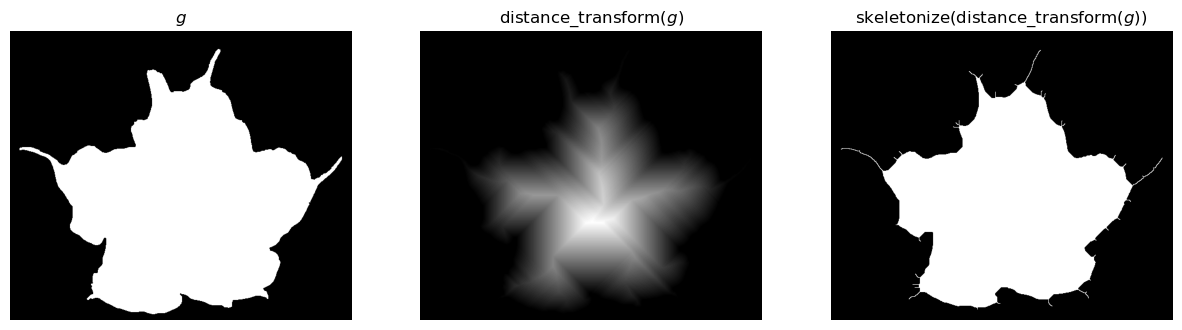

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from imageio.v3 import imread

def local_operator(frame, kernel_size, function):
    
    k, n = kernel_size[0]//2, kernel_size[1]//2
    res_frame = np.zeros_like(frame)
    padded_frame = np.zeros(shape=(frame.shape[0]+2*k, frame.shape[1]+2*n, frame.shape[2]))
    padded_frame[k:-k, n:-n] = frame

    for c in range(padded_frame.shape[2]):
        for i in range(k, padded_frame.shape[0]-k):
            for j in range(n, padded_frame.shape[1]-n):
                curr_frame = padded_frame[i-k:i+k+1,j-n:j+n+1, c]
                res_frame[i-k,j-n, c] = function(curr_frame)
    return res_frame


def distance_transform(frame):
    frame_distances = []

    while frame.sum()>0:
        frame = local_operator(frame=frame, kernel_size=(3,3), function=lambda x: x.min())
        frame_distances.append(frame)

    return np.array(frame_distances).sum(axis=0)


def skeletonize(frame):

    def skeletonize_function(frame):
        frame = frame*kernel
        if frame.sum()==4:
            return 1
        else: 
            return 0
        
    base = np.array([1]*6 + [-1]*3).reshape(3,3)
    base[1,0], base[1,2] = 0, 0
    base2 = np.array([-1]*4+ [1]*5).reshape(3,3)
    base2[0,2], base2[2,0] = 0, 0 

    kernels = [base, base.T, np.flip(base), np.flip(base.T), base2, np.flip(base2,1).T, np.flip(base2,1), np.flip(base2,1).T, np.flip(base2)]
    
    frame = np.where(frame>0, 1, 0)
    for _ in range(10):
        for kernel in kernels:
            frame -= local_operator(frame, kernel_size=(3,3), function=skeletonize_function)
    return frame

frame = imread("images/engelstrompete.png") > 0
frame = frame.reshape(*frame.shape[:2], 1)


imgs = [frame]
for func in [distance_transform, skeletonize]:
    frame = func(frame)
    imgs.append(frame)


fig, axes = plt.subplots(1, 3, figsize=(15,5))
titles = [r"$g$", r"distance_transform$(g)$", r"skeletonize$($distance_transform$(g))$"]

for ax, t, x in zip(axes, titles, imgs):
    ax.imshow(x, cmap="gray")
    ax.set_title(t)
    ax.axis("off");


## Assignment 2: Hough transform (5 points)

**a)** Explain in your own words the idea of Hough transform in general. What is an accumulator space? In what sense can the Hough transform be seen as a model-based approach?

Hough Transfromation: Detection of edge points (location and direction)
 - on piece of a edge results in one point in accumulator space A
 - on cluster of points in A yields straigt lines
    - can also be generalized to other strucutres (eg. circles)
 - between local to global, calculated from points spread over the image but not from all its points 

Accumulator space A:
 -  all detected line segments accumulated in A
 - analysis of cluster required, gives infromation about the straight lines
 - due to errors, rather a cluster than mapped oin a single cell

Model-based approach?:
 - simple from of it
 - straight line specified as model by looking for points/small clusters

**b)** What is linear Hough transform? What does a point in the linear Hough space represent? Explain the meaning of the two coordinates.

Linear Hough transfrom: 
 - each line in image space is represented as point in accumulator space
 - normal from of a line is used in Hough transfrom 
 - transfromed to sinusodial curve in r-$\theta$ parameter space:
    $r = x \cos\theta + y \sin\theta$

Point in Linear Hgh Space represents a line in the image space (r, $\theta$)
 - r: distance if line from the origin
 - $\theta$: orientation of line in the image 

**c)**  How are points, lines, polygons transformed by linear Hough transform? What about parallel lines? Try different configurations using the functions `point`, `line`, `polygon` below. Use the function `skimage.transform.hough_line` to display these examples. 
<!-- You may use the code of Assignment 2 to check different configurations interactively. -->

YOUR ANSWER HERE

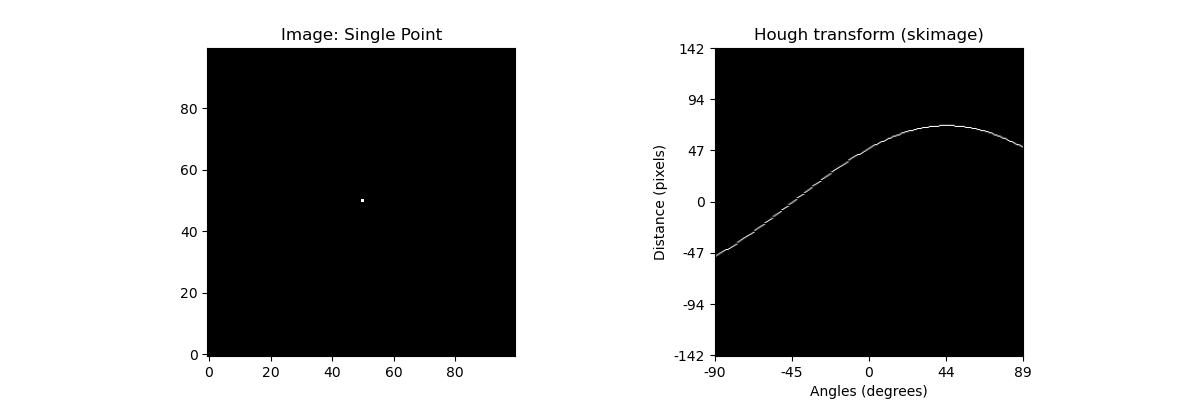

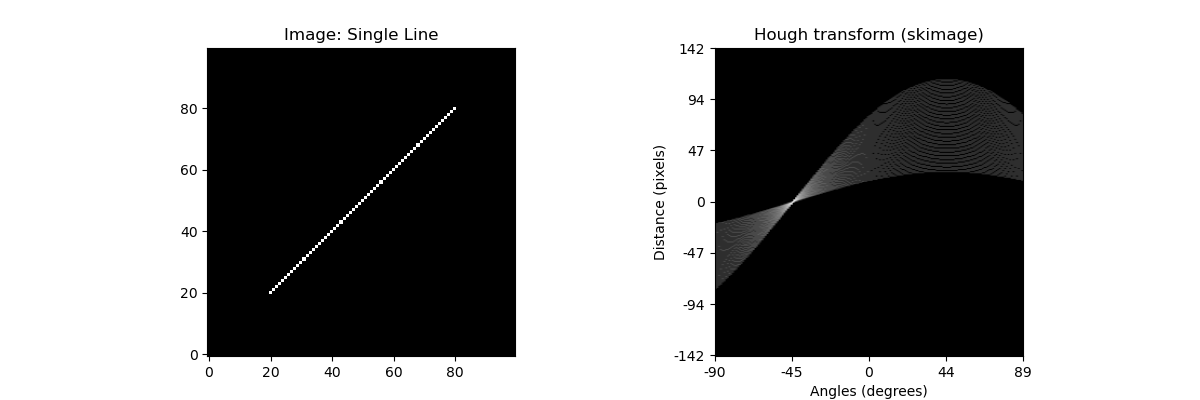

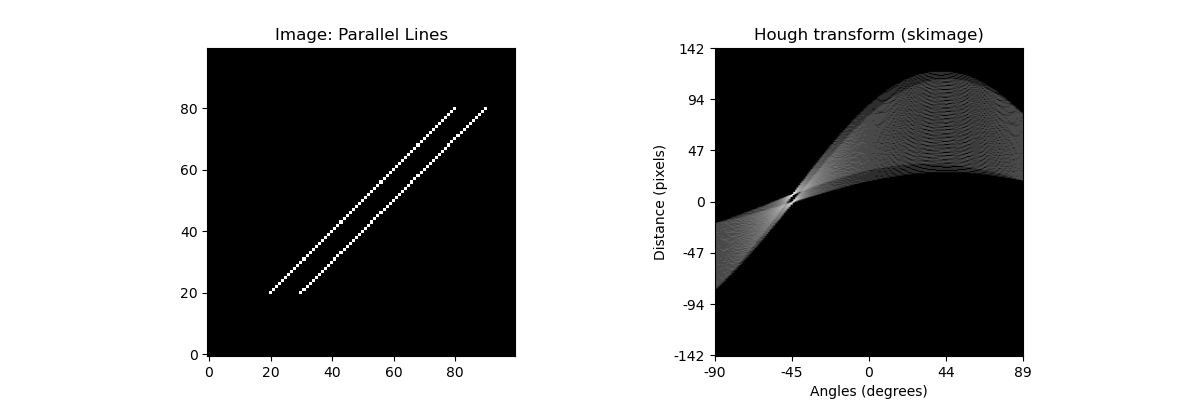

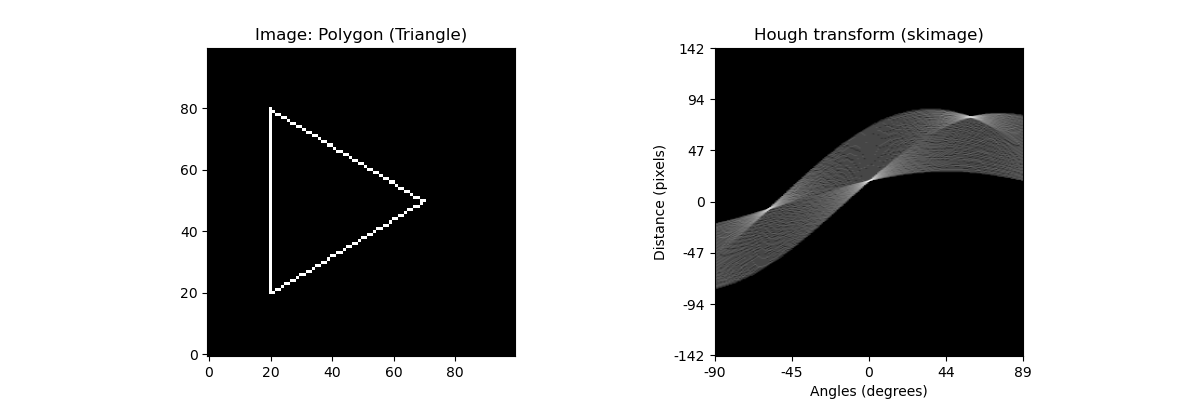

In [5]:
from skimage.transform import hough_line, resize
import matplotlib.pyplot as plt
%matplotlib ipympl
import numpy as np

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    """Insert a point in the black/white image at position p
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of point.
    
    Returns:
    
    """
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image
    
    Args:
        img (ndarray): Input image.
        vertices (list): List of coordinate tuples.
    
    Returns:
    
    """
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)



# YOUR CODE HERE
#raise NotImplementedError()

def plot_hough_transform(img, title):
    
    out, angles, d = hough_line(img)

    fig, [ax1, ax2] = plt.subplots(1,2, figsize=(12,4))

    plt.gray()
    ax1.set_title('Image: ' + title); 
    ax1.imshow(img, origin = 'lower')

    # scale output to quadratic image
    out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
    ax2.set_title('Hough transform (skimage)');
    ax2.set_xlabel('Angles (degrees)')
    ax2.set_ylabel('Distance (pixels)')
    ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')

    ax2.set_yticks(np.linspace(0, out.shape[0], 7))
    ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
    ax2.set_xticks(np.linspace(0, out.shape[0], 5))
    ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))


    plt.show()


# configurations
# Point
img = np.zeros((100, 100), dtype=np.uint8)
point(img, (50, 50))
plot_hough_transform(img, "Single Point")

# Line
img = np.zeros((100, 100), dtype=np.uint8)
line(img, (20, 20), (80, 80))
plot_hough_transform(img, "Single Line")

# Parallel Lines
img = np.zeros((100, 100), dtype=np.uint8)
line(img, (20, 20), (80, 80))
line(img, (20, 30), (80, 90))
plot_hough_transform(img, "Parallel Lines")

# Polygon
img = np.zeros((100, 100), dtype=np.uint8)
polygon(img, [(20, 20), (80, 20), (50, 70)])
plot_hough_transform(img, "Polygon (Triangle)")

**d)** The following code block implements an interactive Hough transform, in which you can either draw points or lines and can see the resulting Hough transform immediately. Draw different shapes of points or lines and check the resulting Hough transform. Try to predict the outcome of the transformation!

point: sinuscurve

line: sinuscurves that accumulate in one point

parallel line: sinuscurves that vary in y-value

polygon: sinuscurves that vary in y- and x-values

In [ ]:
%matplotlib ipympl
from skimage.transform import hough_line, resize
import matplotlib.pyplot as plt
import numpy as np

# True if two mouse clicks should draw a line, false if single clicks draw points
lines = True

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])
img = np.zeros((200,200))


def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1
    

def disp_and_comp():
    """Computes Line Hough transform; displays image and result
    
    Args:
    
    Returns:
    
    """
    ax1.imshow(img, origin = 'lower', cmap='gray')
    
    out, angles, d = hough_line(img)
    
    out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
    ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
    ax2.set_yticks(np.linspace(0, out.shape[0], 7))
    ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
    ax2.set_xticks(np.linspace(0, out.shape[0], 5))
    ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))
    
    fig.canvas.draw()

    
first_point = True
p1 = (0,0)
def on_press(event):
    """Draws either line or point and calls disp_and_comp
    
    Reacts to mouse clicks. Draws either point at mouse
    position and computes Hough transform or draws line
    between first and second mouse click and then computes
    hough transfom.
    
    Args:
        event (event): Mouseevent.
    
    Returns:
    
    """
    global p1, first_point
    y = int(event.xdata)
    x = int(event.ydata)
    
    if (lines):
        if (first_point):
            p1 = (x,y)
            img[x, y] = 255
            first_point = False
        else:
            line(img,p1,(x,y)) 
            first_point = True
        disp_and_comp()
    else:
        img[x, y] = 255
        disp_and_comp()   

fig = plt.figure(figsize=(8, 6))

ax1 = fig.add_subplot(121)
plt.title('Image')

ax2 = fig.add_subplot(122)
plt.title('Hough transform');
plt.xlabel('Angles (degrees)')
plt.ylabel('Distance (pixels)')
plt.tight_layout()
plt.axis('square')

disp_and_comp()
cnc = fig.canvas.mpl_connect('button_press_event', on_press)

# YOUR CODE HERE
raise NotImplementedError()

## Assignment 3: Implementing Hough transform (5 points)

In [11]:
# Auxiliary functions for this exercise
import numpy as np
from skimage.transform import hough_line, resize

steps = lambda p,q : max(map(lambda x,y: abs(x-y), p, q))+1
coords = lambda p,q,s : tuple([np.linspace(x,y,s,dtype=np.uint16) for x,y in zip(p,q)])

def point(img, p):
    """Insert a point in the black/white image at position p
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of point.
    
    Returns:
    
    """
    img[p] = 1

def line(img, p, q):
    """Insert a line from p to q in the black/white image
    
    Args:
        img (ndarray): Input image.
        p (tuple): Coordinate of start position.
        q (tuple): Coordinate of end position.
    
    Returns:
    
    """
    img[coords(p,q,steps(p,q))] = 1

def polygon(img, vertices):
    """Insert a (closed) polygon given by a list of points into the black/white image
    
    Args:
        img (ndarray): Input image.
        vertices (list): List of coordinate tuples.
    
    Returns:
    
    """
    for p, q in zip(vertices, vertices[1:]+vertices[0:1]):
        line(img,p,q)

**a)** Implement your own version of linear Hough transform and compare the results with the function `skimage.transform.hough_line`.

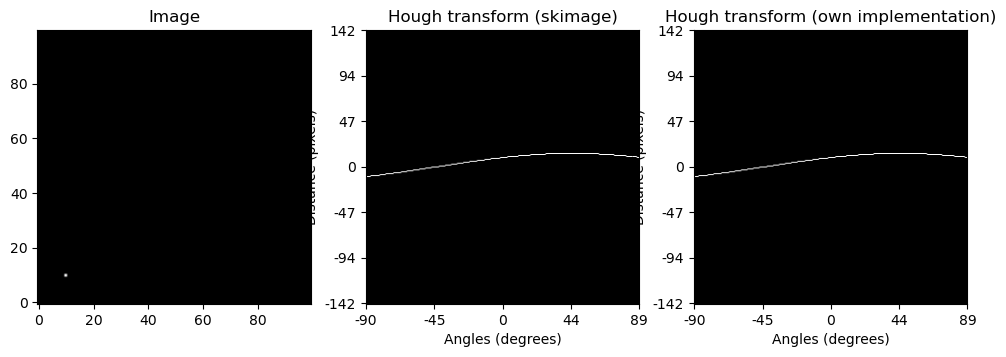

In [13]:
from skimage.transform import hough_line
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import warnings
warnings.filterwarnings('ignore')

def my_hough_line(img, angles=180):
    """
    Apply linear Hough transform to the given image.
    
    Args:
        img (numpy.ndarray): The binary image to transform
        angles (int): The number of angles to consider.
    Result:
        accumulator (numpy.ndarray): The accumulator space.
    """
    # YOUR CODE HERE
      # Create the accumulator
    diag_len = int(np.ceil(np.sqrt(img.shape[0]**2 + img.shape[1]**2)))  # Max possible r
    r_bins = 2 * diag_len + 1  # Include negative distances
    accumulator = np.zeros((r_bins, angles), dtype=np.uint64)
    
    # Define theta values
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, angles)
    
    # Find all non-zero points in the image
    y_idxs, x_idxs = np.nonzero(img)
    
    # Populate the accumulator
    for x, y in zip(x_idxs, y_idxs):
        for theta_idx, theta in enumerate(theta_range):
            r = int(x * np.cos(theta) + y * np.sin(theta))  # Compute r
            r_idx = r + diag_len  # Shift r to non-negative indices
            accumulator[r_idx, theta_idx] += 1  # Increment the accumulator bin
    
    return accumulator

img = np.zeros((100,100))

# You may try different paintings here:
point(img, (10,10))
#line(img,(10,20),(70,20))
#polygon(img,[(20,10),(80,50),(80,80),(30,60)])


fig, [ax1, ax2, ax3] = plt.subplots(1,3, figsize=(12,4))
plt.gray()

# original image
ax1.set_title('Image'); 
ax1.imshow(img, origin = 'lower')

# skimage
out, angles, d = hough_line(img)

out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax2.set_title('Hough transform (skimage)')
ax2.set_xlabel('Angles (degrees)')
ax2.set_ylabel('Distance (pixels)')
ax2.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
ax2.set_yticks(np.linspace(0, out.shape[0], 7))
ax2.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax2.set_xticks(np.linspace(0, out.shape[0], 5))
ax2.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

# own implementation
my_out = my_hough_line(img)

my_out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax3.set_title('Hough transform (own implementation)')
ax3.set_xlabel('Angles (degrees)')
ax3.set_ylabel('Distance (pixels)')
ax3.imshow(np.log(1 + my_out_resized), origin = 'lower', cmap='gray')
ax3.set_yticks(np.linspace(0, out.shape[0], 7))
ax3.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax3.set_xticks(np.linspace(0, out.shape[0], 5))
ax3.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

plt.show()

**b)** Under which conditions is (linear) Hough transform invertible? Try to implement an inverse linear Hough transform. 

You could create a line for each point in accumulator space by doing the following: Compute angle and distance of the line represented by the current point in accumulator space. Add the value of this point to all image pixels which belong to the corresponding line. Finally you could threshold the image. 

However, other solution are feasible, too.


YOUR ANSWER HERE

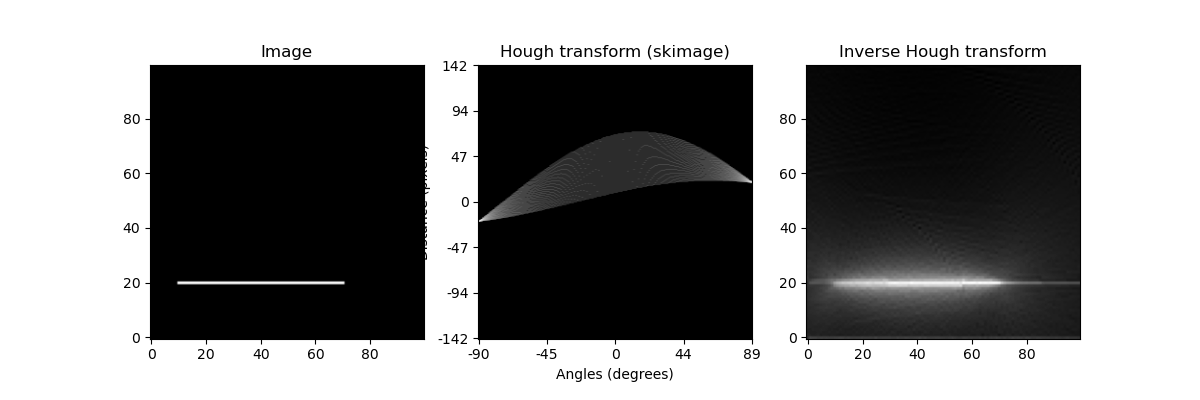

In [14]:
%matplotlib ipympl 
from skimage.transform import hough_line
import matplotlib.pyplot as plt
import numpy as np

# YOUR CODE HERE
#raise NotImplementedError()

def my_inverse_hough_line(accumulator, shape):
    """Compute an inverse Hough transform, i.e. compute the image from the accumulator space.
    
    Args:
        accumulator (numpy.ndarray)
        shape (tuple): The shape (dimensions) of the image to be created

    Result:
        img (numpy.ndarray): The image created from the accumulator space.
    """
    img = np.zeros(shape, np.uint64)
    
    img = np.zeros(shape, dtype=np.uint64)  # Initialize the output image
    diag_len = int(np.ceil(np.sqrt(shape[0]**2 + shape[1]**2)))
    r_bins, theta_bins = accumulator.shape
    
    # Define the theta and r ranges
    theta_range = np.linspace(-np.pi / 2, np.pi / 2, theta_bins)
    r_range = np.linspace(-diag_len, diag_len, r_bins)
    
    # Iterate through the accumulator
    for r_idx in range(r_bins):
        for theta_idx in range(theta_bins):
            value = accumulator[r_idx, theta_idx]
            if value > 0:  # Only process non-zero entries
                r = r_range[r_idx]
                theta = theta_range[theta_idx]
                
                # Compute the corresponding line in image space
                for x in range(shape[1]):  # Loop through x-coordinates
                    y = int((r - x * np.cos(theta)) / np.sin(theta))
                    if 0 <= y < shape[0]:  # Ensure valid coordinates
                        img[y, x] += value  # Add the accumulator value to the pixel
    
    return img

img = np.zeros((100,100))

#point(img, (10,10))
#line(img,(10,20),(70,20))
line(img,(20,10),(20,70))
#polygon(img,[(10,30),(50,50),(10,70)])

plt.figure(figsize=(12, 4))
plt.gray()
plt.subplot(1,3,1) ; plt.title('Image'); plt.imshow(img, origin = 'lower')

out, angles, d = hough_line(img)
out_resized = resize(out, (out.shape[0], out.shape[0]), anti_aliasing=True, preserve_range=True)
ax = plt.subplot(1,3,2) ; plt.title('Hough transform (skimage)')
ax.set_title('Hough transform (skimage)')
ax.set_xlabel('Angles (degrees)')
ax.set_ylabel('Distance (pixels)')
ax.imshow(np.log(1 + out_resized), origin = 'lower', cmap='gray')
ax.set_yticks(np.linspace(0, out.shape[0], 7))
ax.set_yticklabels((-1 * np.linspace(d[-1], d[0], 7)).astype(int))
ax.set_xticks(np.linspace(0, out.shape[0], 5))
ax.set_xticklabels(np.linspace(np.rad2deg(angles[0]), np.rad2deg(angles[-1]), 5).astype(int))

img2 = my_inverse_hough_line(out, img.shape)
plt.subplot(1,3,3) ; plt.title('Inverse Hough transform')
plt.imshow(img2, origin = 'lower')
plt.show()

## Assignment 4: Circular Hough (5 points)

**a)** Explain the idea of circular Hough transform. How many dimensions does the accumulator space have and what do they represent? What practical problems do you expect when computing circular Hough transform?

Circular Hough Transform:

Idea: Hough Transfrom especially for circles

Dimensions of accumulator space:
Three Dimensions: xc, yc, r 

Dimensions represent:
xc and yc are the image plane
radius = r 

Expected practical problems when computing circular Hough Transform:
overlapping circles 
high comp power bc of 3 dimensionality
ellipses or half-circles confuse transform, leading to incorrect detections



**b)** Now implement circular hough transform. First think how the accumulator space should be represented. You may provide an additional parameter to only look for circles of a given radius (or a range of radii). Then apply it to the image `xmas.png` to detect the balls. Mark them in the original image. (Bonus task: also detect the presents using linear Hough transform).

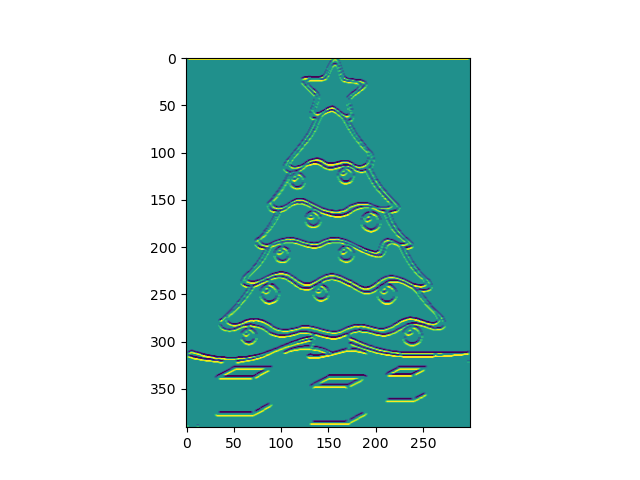

In [ ]:
# mein versuch LOL

%matplotlib ipympl
from skimage.transform import hough_line
from skimage.transform import hough_circle
import scipy
from scipy import misc
from imageio.v3 import imread
import matplotlib.pyplot as plt
import numpy as np

# load the image
img = imread('images/xmas.png')
xkern = np.array([[-1, 0, 1], [-1, 0, 1], [-1, 0, 1]])
ykern = np.array([[-1, -1, -1], [0, 0, 0], [1, 1, 1]])
# start with edge point detection
xgrad = scipy.signal.convolve2d(img, xkern)
ygrad = scipy.signal.convolve2d(img, ykern)
plt.imshow(xgrad)
plt.imshow(ygrad) 
plt.show()
# compute matrix from input image g(x,y) of its gradient magnitude G(x,y)
grad_magni = np.sqrt(pow(xgrad,2) + pow(ygrad,2))
# compute matrix from input image g(x,y)of its gradient direction 0(x,y)

def grad_direct(xgrad, ygrad):
    if xgrad > 0 and ygrad >= 0:
        return np.arctan(ygrad / xgrad)
    elif xgrad < 0:
        return np.pi + np.arctan(ygrad / xgrad)
    elif xgrad > 0 and ygrad < 0:
        return 2 * np.pi + np.arctan(ygrad / xgrad)

# initialise accumulator space
#radius
#x
#y

# increment the counters in A along a circle of radius r around each edge pixel
# accumulation points are centers of circles 

# apply circular hough transform to image 

#plt.imshow(np.squeeze(hough_circle(img, 3))



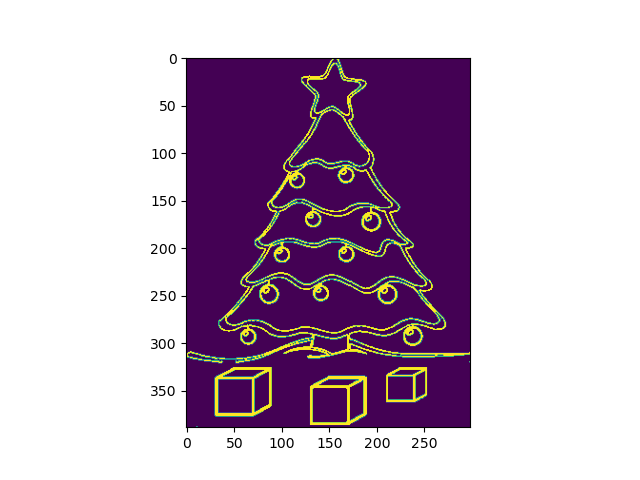

In [23]:
%matplotlib ipympl
from skimage.transform import hough_line
from skimage.transform import hough_circle
import scipy
from scipy import misc
from imageio.v3 import imread
import matplotlib.pyplot as plt
import numpy as np

# load the image
img = imread('images/xmas.png')

def hough_circle(edges, radius):
    height, width = edges.shape
    accumulator = np.zeros((height, width), dtype=np.int32)
    
    # Durchlaufe alle Kantenpunkte
    for y in range(height):
        for x in range(width):
            if edges[y, x] > 0:  # Kantenpunkt
                # Gradientenwinkel bestimmen
                grad_angle = np.arctan2(y, x)
                
                # Potenzielle Kreiszentren berechnen
                x_center = int(x - radius * np.cos(grad_angle))
                y_center = int(y - radius * np.sin(grad_angle))
                
                if 0 <= x_center < width and 0 <= y_center < height:
                    accumulator[y_center, x_center] += 1
    
    return accumulator

hough_circle(img,2)

plt.imshow(img) 
plt.show()